In [1]:
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [2]:
train_data = datasets.MNIST(
    root = 'data',
    train = True,
    download = True,
    transform = ToTensor()
)
test_data = datasets.MNIST(
    root = 'data',
    train = False,
    download = True,
    transform = ToTensor()
)

In [3]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [4]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [5]:
train_data.data.size()

torch.Size([60000, 28, 28])

In [6]:
test_data.data.shape

torch.Size([10000, 28, 28])

In [7]:
train_data.targets.shape

torch.Size([60000])

In [8]:
test_data.targets

tensor([7, 2, 1,  ..., 4, 5, 6])

In [9]:
from torch.utils.data import DataLoader

loaders = {

    'train' : DataLoader(train_data,
                         batch_size=100,
                         shuffle=True),
    'test' : DataLoader(test_data,
                        batch_size=100,
                        shuffle=True)    
}

In [10]:
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x2040d307d70>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x2040d2c3cb0>}

In [11]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(1,10, kernel_size = 5)
        self.conv2 = nn.Conv2d(10,20, kernel_size = 5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320,50)
        self.fc2 = nn.Linear(50,10)
    
    def forward(self, X):
        x = F.relu(F.max_pool2d(self.conv1(X), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)  # Flatten
        x = F.relu(self.fc1(x))  # Use self.fc1(x) to get the tensor output
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)

        return F.softmax(x, dim=1)


In [12]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CNN().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr= 0.001)

loss_fn = nn.CrossEntropyLoss()

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(loaders['train']):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 20 == 0:
            print(f"Train epoch = {epoch}, [{batch_idx*len(data)}/{len(loaders['train'].dataset)}({100.0*batch_idx/len(loaders['train']):.0f}%)]\t { loss.item():.6f}")

def test():
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for test_data, target in loaders['test']:
            test_data, target = test_data.to(device), target.to(device)
            output = model(test_data)
            test_loss += loss_fn(output, target).item()
            pred = output.argmax(dim =1, keepdim= True)
            correct += pred.eq(target.view_as(pred)).sum().item()

            test_loss /= len(loaders['test'].dataset)
            print(f"\n Test set : Average loss = {test_loss:.4f}, Accuracy: {correct}/{len(loaders['test'].dataset)}, ({100.0 * correct / len(loaders['test'].dataset):.0f}%)\n")





In [13]:
for epoch in [1, 11]:
    train(epoch)
    test()
    

Train epoch = 1, [0/60000(0%)]	 2.302117
Train epoch = 1, [2000/60000(3%)]	 2.273875
Train epoch = 1, [4000/60000(7%)]	 2.187881
Train epoch = 1, [6000/60000(10%)]	 2.003567
Train epoch = 1, [8000/60000(13%)]	 1.904189
Train epoch = 1, [10000/60000(17%)]	 1.831333
Train epoch = 1, [12000/60000(20%)]	 1.829540
Train epoch = 1, [14000/60000(23%)]	 1.770733
Train epoch = 1, [16000/60000(27%)]	 1.727699
Train epoch = 1, [18000/60000(30%)]	 1.722036
Train epoch = 1, [20000/60000(33%)]	 1.768631
Train epoch = 1, [22000/60000(37%)]	 1.708132
Train epoch = 1, [24000/60000(40%)]	 1.705231
Train epoch = 1, [26000/60000(43%)]	 1.777377
Train epoch = 1, [28000/60000(47%)]	 1.706377
Train epoch = 1, [30000/60000(50%)]	 1.691457
Train epoch = 1, [32000/60000(53%)]	 1.644214
Train epoch = 1, [34000/60000(57%)]	 1.672694
Train epoch = 1, [36000/60000(60%)]	 1.567637
Train epoch = 1, [38000/60000(63%)]	 1.705605
Train epoch = 1, [40000/60000(67%)]	 1.653181
Train epoch = 1, [42000/60000(70%)]	 1.584570

Prediction: 7


c:\Users\karti\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\functional.py:1381: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn("dropout2d: Received a 3D input to dropout2d and assuming that channel-wise "


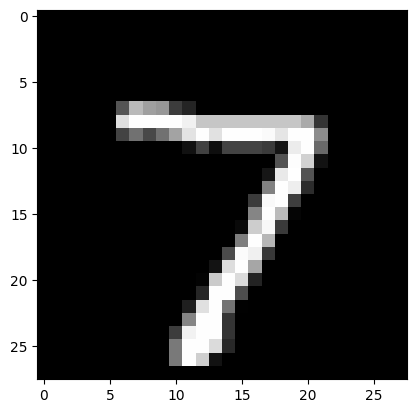

In [14]:
import matplotlib.pyplot as plt

model.eval()

data, target = test_data[0]

test_data = data.unsqueeze(1).to(device)

output = model(data)

prediction = output.argmax(dim=1, keepdim = True).item()

print(f'Prediction: {prediction}')

image = data.squeeze(0).squeeze(0).cpu().numpy()

plt.imshow(image, cmap= 'gray')

plt.show()